In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/fin_mic_bin")

In [0]:
import numpy as np
import glob
import os
from scipy.misc import imsave
import imageio
import pandas as pd
x=pd.read_csv('trainLabels.csv')
for i in x:
    file=open("train/"+str(x['Id'][i])+".bytes")
    ln=os.path.getsize("train/"+str(x['Id'][i])+".bytes")
    kbs=ln/1024
    #f=open("train/"+str(x['Id'][i])+".bytes",'rb')
    out = file.readlines()
    count = 0
    arr = ''
    arr2=[]
    for line in out:
        line2 = line.split(' ', 1)[1]
        line3 = line2.split(' ')
        for l in line3:
            try:
                binval = '{:08b}'.format(int(l, 16))
                arr += str(binval)
            except:
                count += 1
       
    arr2 = [arr[start:start+8] for start in range(0, len(arr), 8)]

    # making decimal values and saving them in file
    decval_list = []
    for a in arr2:
        decval = int(a, 2)
        decval_list.append(decval)
        #file2.write(str(decval)+" ")

    lengthoflist = len(decval_list)
    #print(decval_list)
    width= 1024
    width= 1024
    if(kbs>0 and kbs<10):
        width= 32
    elif(kbs>=10 and ln<30):
        width= 64
    elif(kbs>=30 and ln<60):
        width= 128
    elif(kbs>=60 and ln<100):
        width= 256
    elif(kbs>=100 and ln<200):
        width= 384
    elif(kbs>=200 and ln<500):
        width= 512
    elif(kbs>=500 and ln<1000):
        width= 768
    rem= lengthoflist%width
    decval_list=decval_list[0:lengthoflist-rem]
    g=np.reshape(decval_list,(int(len(decval_list)/width),width))
    #print(g.shape)
    imsave("bytes_img/"+str(x['Id'][i])+'.png',g)
    os.remove("train/"+str(x['Id'][i])+".bytes")
    print(i)

In [0]:
from keras.preprocessing.image import ImageDataGenerator as idg
from keras.models import Sequential as seq
from keras.layers import Conv2D
from keras.layers import MaxPooling2D as MaxP2D
from keras.layers import Dense, Flatten, Dropout
import os

Using TensorFlow backend.


In [0]:
import pandas as pd
import numpy,scipy.misc, os, array
from scipy.misc import imsave
#import pandas as pd
import numpy,scipy.misc, os, array
import cv2
x=pd.read_csv('trainLabels.csv')
for i in range (0,len(x)):
    image=cv2.imread("bytes_img/"+str(x['Id'][i])+".png")
    resized = cv2.resize(image,(256,256))
    cv2.imwrite("bs_img/c"+str(x['Class'][i])+"/"+str(x['Id'][i])+".png", resized)

In [0]:
image_width, image_height = 224,224
rescl = 1. / 255

training_dir = 'bs_img/'


In [0]:
from keras.applications.vgg16 import VGG16
vgg = seq()
vgg.add(Conv2D(3,[3,3],strides=1,padding='same',activation='relu',
                        input_shape=(image_width, image_height, 1)))
_vgg = VGG16(weights='imagenet', include_top=False)
counter=0
for layer in _vgg.layers:
    layer.trainable = False
    counter+=1
print("VGG's ", counter , " layers are not added to the layer")
vgg.add(_vgg)
print("done")
vgg.add(Flatten())

vgg.add(Dense(4096,activation='relu'))
vgg.add(Dropout(0.5))
vgg.add(Dense(9,activation="softmax"))
from keras.optimizers import SGD
SGD(lr=0.001, momentum=0.9, decay=0.0005)
vgg.compile(loss='categorical_crossentropy',
              optimizer='SGD',
              metrics=['accuracy'])
#vgg.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
VGG's  19  layers are not added to the layer
done
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 3)       30        
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 36873     
Total params: 117,516,135
Trainable params: 102,801,447
Non-trainable params: 14,714,688
_____________________________________________________

In [0]:
bs = 100
epoch  = 30
train_datagen = idg(
    rescale=rescl,
    validation_split=0.3)
    #shear_range=0.2,
    #zoom_range=0.2,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    #)
    
traincomplete_datagen = idg(
    rescale=rescl)
    #shear_range=0.2,
    #zoom_range=0.2,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True,
    #)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(image_width, image_height),
    batch_size=bs,
    color_mode="grayscale",
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(image_width, image_height),
    batch_size=bs,
    color_mode="grayscale",
    class_mode='categorical',
    subset='validation')

history= vgg.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//bs,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//bs)
)

Found 7606 images belonging to 9 classes.
Found 3253 images belonging to 9 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
76/76 [==============================] - 187s 2s/step - loss: 2.2344 - acc: 0.4778 - val_loss: 0.9146 - val_acc: 0.7925
Epoch 2/30
76/76 [==============================] - 175s 2s/step - loss: 0.8243 - acc: 0.7359 - val_loss: 0.7032 - val_acc: 0.7586
Epoch 3/30
76/76 [==============================] - 169s 2s/step - loss: 0.5777 - acc: 0.8193 - val_loss: 0.5051 - val_acc: 0.8271
Epoch 4/30
76/76 [==============================] - 169s 2s/step - loss: 0.5247 - acc: 0.8465 - val_loss: 0.4231 - val_acc: 0.8827
Epoch 5/30
76/76 [==============================] - 170s 2s/step - loss: 0.4306 - acc: 0.8684 - val_loss: 0.3842 - val_acc: 0.8757
Epoch 6/30
76/76 [==============================] - 169s 2s/step - loss: 0.4320 - acc: 0.8649 - val_loss: 0.3399 - val_acc: 0.8934
Epoch 7/30
76/76 [==============================] - 169s 2s/step - loss: 0.3608 - 

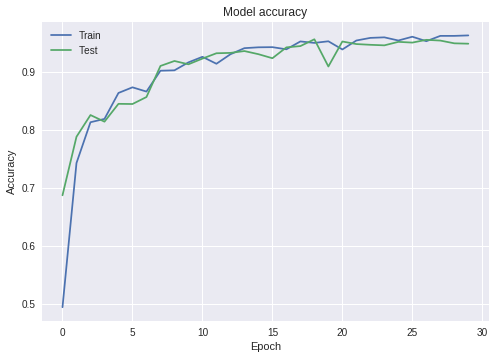

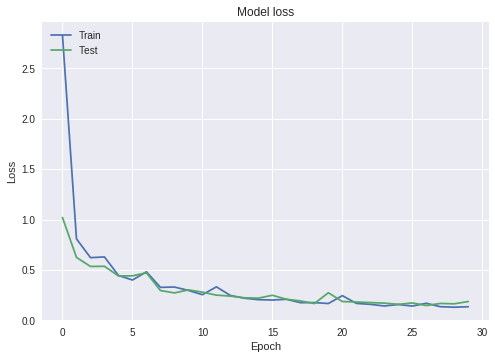

In [0]:
import matplotlib.pyplot as plt


# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()